##### ECON 323: Quantitative Economic Modelling with Data Science Applications - Final Project (2023 W2)

<p align="center" style="font-weight:bold; font-size:20px;">Analyzing the Impact of Engine Selection on Formula 1 Team Performance</p>


* Anna Czarnocka
* Gabor Swistak
* Ansh Varma
* Camilo Ulloa

### Abstract 
Through this project, as part of ECON 323,  we aim to dive into the highly competitive world of Formula 1 racing, specifically investigating the relationship between engine selection and team performance. 

The secretive nature of engine specifications in Formula 1 prompted us to analyze the impacts of engine choice on team performance. Since a direct analysis of engine performance characteristics is not possible, we adopted an indirect approach, employing econometric methods to analyze available data such as race outcomes, qualifying positions, lap times, and other performance indicators across multiple seasons.

Our methodology involves web scrapping to gathering data on each Formula 1 team, including their engine suppliers, and correlating this with their performance metrics. We will  use Python for web scrapping, data collectiom and cleaning, and perform an exploratory data analysis from the gathered dataset.

We hypothesize that engine choice has a significant impact on team performance, influenced by factors like engine power, reliability, and the synergies between the engine manufacturers and the teams. Our analysis will control for variables such as team budget, driver skill, and technological advancements to isolate the effect of the engine choice.

## Part A: Building the Data Set
We will start by developing web scrappinging models to gather and compile data for our analysis. 




In [ ]:
import requests
from bs4 import BeautifulSoup
from csv import writer
import pandas as pd
import numpy as np
from selenium import webdriver
import time
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from contextlib import contextmanager


### Web Scrapping Model

In this section, we focus on using web scraping to gather data on all Formula 1 teams that participated in races from 2014 to 2023.

Our decision to analyze data starting from 2014 is informed by significant regulatory changes in F1 car engines that year. These changes include:
* a shift from V8 to V6 cylinders
* modifications in horsepower, weight, and fuel specifications 

Therefore, restricting the scope to races between 2014 and 2023 will keep our analysis consistent

In [3]:
class F1TeamScraper:
    def __init__(self, base_url):
        self.base_url = base_url
        self.teams_data = []

    def scrape_teams_for_year(self, year):
        url = self.base_url.format(year) # We introduce the format of "year" so later we can loop through the range of years of interest
        page = requests.get(url)
        try:
            soup = BeautifulSoup(page.content, 'html.parser')
        except page.status_code != 200: # If the status code of the page is != 200 it means Beautiful Soup could read correctly the web page and access its information. 
            pass
        table = soup.find('table') # We will look for the element "table" in the HTML code
        rows = table.find_all('tr')[1:] # Then we will find the father element "tr"
        teams = [row.find_all('td')[2].text.strip() for row in rows] # Finally we will extract the information from the son "td" where is the information regarding the teams
        self.teams_data.extend([(year, team) for team in teams])

    def scrape_range_of_years(self, start_year, end_year):
        for year in range(start_year, end_year + 1): # We loop throught our years of interest 2014-2023
            self.scrape_teams_for_year(year)

    def get_teams_data(self):
        return pd.DataFrame(self.teams_data, columns=['Year', 'Teams']) # Finally it returns a Data Frame with the data

# Initiate the scraper with the base URL
scraper = F1TeamScraper("https://www.formula1.com/en/results.html/{}/team.html") 

# Scrape the team data for the range of years 2014-2023
scraper.scrape_range_of_years(2014, 2023)

# Retrieve the scraped data as a DataFrame
f1_teams_df = scraper.get_teams_data()

f1_teams_df.head()


,Year,Teams
0,2014,Mercedes
1,2014,Red Bull Racing Renault
2,2014,Williams Mercedes
3,2014,Ferrari
4,2014,McLaren Mercedes


In [ ]:
# Define a class for scraping F1 team data
class F1TeamScraper:
    # Constructor to initialize the scraper with a base URL
    def __init__(self, base_url):
        self.base_url = base_url  # Base URL for scraping
        self.teams_data = []  

    # Method to scrape teams for a specific year
    def scrape_teams_for_year(self, year):
        url = self.base_url.format(year)  
        page = requests.get(url)  
        try:
            soup = BeautifulSoup(page.content, 'html.parser')  
        except page.status_code != 200:  # Handle exceptions for unsuccessful page requests
            pass
        table = soup.find('table')  # Find the table in the page
        rows = table.find_all('tr')[1:]  
        teams = [row.find_all('td')[2].text.strip() for row in rows] 
        self.teams_data.extend([(year, team) for team in teams])  # Add (year, team) tuples to the teams data list

    # Method to scrape team data over a range of years
    def scrape_range_of_years(self, start_year, end_year):
        for year in range(start_year, end_year + 1):  
            self.scrape_teams_for_year(year)  # Scrape teams for each year

    # Method to get the scraped teams data as a DataFrame
    def get_teams_data(self):
        return pd.DataFrame(self.teams_data, columns=['Year', 'Teams'])  # Return teams data as a DataFrame

# Create an instance of the scraper with the specific URL
scraper = F1TeamScraper("https://www.formula1.com/en/results.html/{}/team.html") 

# Scrape team data for the years 2014 to 2023
scraper.scrape_range_of_years(2014, 2023)

f1_teams_df = scraper.get_teams_data()

f1_teams_df.head()


In [4]:
f1_teams_df.shape

(103, 2)

In [5]:
f1_teams_df.to_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/f1_teams.csv") # Saving the first table

In [4]:
f1_teams_df = pd.read_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/f1_teams.csv")

Now that we have collected data on all Formula 1 teams for our timeframe (2014 to 2023), we want to gather additional data regarding each participating team, including:

1. Each Team's engine choice  across years (since engine selection by teams varies across seasons)
2. Total number of accumulated points 
3. Total number of pole positions achieved 
4. Total Wins
5. Number of fastest laps 
6. Final world championship position at the end of each season

Before we proceed to extract this  information, it's necessary to refine the **f1_teams_df** dataframe. Our primary task is to create a new column that captures only the team name, excluding any engine or sponsor names. 

For instance, in 2014, 'Red Bull Racing Renault' should be simplified to 'Red Bull Racing'

This step is crucial as it allows us to accurately match and extract the additional data for each team across our years of analysis.

This highlights the challenges of creating one's own web scrapped data set, in showing the  manual modifications that are needed to keep the data consistent before performing  analysis.

In [8]:
def extract_and_format_team_names(df):
    # Extracting team names and formatting them: lower case and replace spaces with hyphens
    df['Team Name'] = df['Teams'].apply(
        lambda x: ' '.join(x.split()[:3]).lower().replace(' ', '-') if 'Racing' in x else x.split()[0].lower()
    )
    return df

f1_teams_formatted_df = extract_and_format_team_names(f1_teams_df)
f1_teams_formatted_df = f1_teams_formatted_df.drop("Unnamed: 0", axis=1)
f1_teams_formatted_df.head()


,Year,Teams,Team Name
0,2014,Mercedes,mercedes
1,2014,Red Bull Racing Renault,red-bull-racing
2,2014,Williams Mercedes,williams
3,2014,Ferrari,ferrari
4,2014,McLaren Mercedes,mclaren


Given that we are using team names from the official Formula 1 website as keys to fetch additional data from other websites, we encountered some issues in the form of variations in team naming conventions. 

Therefore, it was necessary to adjust the team names in our dataset to align with those used on the Motorsport website. This step ensures that our web scraping model accurately recognizes team names, enabling the successful extraction of all relevant data.

In [9]:
f1_teams_formatted_df['Team Name'] = f1_teams_formatted_df['Team Name'].replace('ferrari', 'ferrari-2')
f1_teams_formatted_df['Team Name'] = f1_teams_formatted_df['Team Name'].replace('lotus', 'lotus-f1')
f1_teams_formatted_df['Team Name'] = f1_teams_formatted_df['Team Name'].replace('racing-point-bwt', 'bwt-racing-point-f1-team')
f1_teams_formatted_df['Team Name'] = f1_teams_formatted_df['Team Name'].replace('alphatauri', 'scuderia-alphatauri-honda')
f1_teams_formatted_df['Team Name'] = f1_teams_formatted_df['Team Name'].replace('alfa-romeo-racing', 'alfa-romeo')
f1_teams_formatted_df['Team Name'] = f1_teams_formatted_df['Team Name'].replace('alfa', 'alfa-romeo')
f1_teams_formatted_df['Team Name'] = f1_teams_formatted_df['Team Name'].replace('aston', 'aston-martin')
f1_teams_formatted_df['Team Name'] = f1_teams_formatted_df['Team Name'].replace('force', 'force-india')
f1_teams_formatted_df.head()

,Year,Teams,Team Name
0,2014,Mercedes,mercedes
1,2014,Red Bull Racing Renault,red-bull-racing
2,2014,Williams Mercedes,williams
3,2014,Ferrari,ferrari-2
4,2014,McLaren Mercedes,mclaren


In [59]:
f1_teams_formatted_df.to_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/f1_teams_formatted.csv") 

## Data Table

Now that we have the **f1_teams_formatted_df** table, which is a refined version of our earlier table, we can move forward with extracting the additional relevant data! 

We will extract this data from the Motorsport Stats webpage. As this site is dynamic and relies on JavaScript for content rendering, we will utilize the Selenium library to access and retrieve the data. Selenium, functioning like a bot, enables navigation and interaction with web pages, making it an ideal tool for our purposes. We will then use Beautiful Soup to parse the acquired data.

Selenium's ability to simulate user interactions is particularly beneficial for navigating through dynamic content. This makes it a valuable tool for our current web scraping needs.

In [29]:
class F1TeamDataScraper:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.team_years = self.extract_teams_and_years()
        '''
        Selenium uses a Web Driver that is a collection of open source APIs which are used to automate the testing of a web application.
        Therefore, we need to download the Web Driver that is compatible with our current version of Google Chrome and insert it's location.
        '''
        self.driver = webdriver.Chrome("/usr/local/bin/chromedriver") 

    def extract_teams_and_years(self):
        '''
        With this function, we aim to extract the unique teams and the years that each unique team has raced for our time of analysis. 
        The objective is to create a list that we can loop throught later for obtaining the data of interest.
        '''
        team_years_list = []
        for team in self.dataframe['Team Name'].unique():
            years = self.dataframe[self.dataframe['Team Name'] == team]['Year'].unique()
            team_years_list.append((team, years))
        return team_years_list

    def scrape_data_for_team(self, team, years):
        '''
        This function is the web scraping model for obtaining our desired data
        '''
        self.driver.get(f"https://www.motorsportstats.com/team/{team}/summary/series/fia-formula-one-world-championship")
        time.sleep(5) # We add this time sleep so we can give time to the dynamic web page to charge and show us information
        page_source = self.driver.page_source
        soup = BeautifulSoup(page_source, 'html.parser')
        time.sleep(2)  
        
        summary_table = soup.find("table") 
        if summary_table is None: # We use this conditional to prove that there exist data for the team we are scraping its data
            print(f"No data found for team: {team}")
            return pd.DataFrame()  # Return an empty DataFrame if no table found

        rows = summary_table.find_all("tr") # Again "tr" is the father in the HTML code

        # Extracting table headers
        headers = [header.get_text().strip() for header in rows[0].find_all("th") if header.get_text().strip() != "Drivers"]
        
        data = []
        for row in rows[1:]:  # Skip the header row
            cols = row.find_all("td")
            year_text = cols[0].get_text().strip() # With this we are obtaining the years from the table of the web page
            if year_text.isdigit():
                year = int(year_text)
                if year in years:
                    '''
                    With this conditional we are checking if the year we got previously, exist in the data we have as reference from "f1_teams_formatted_df".
                    If it happens to exist, then we extract all the data of the column regarding that year
                    '''
                    filtered_cols = [col.get_text().strip() for col in cols if col != cols[1]]
                    if len(filtered_cols) == len(headers):
                        data.append(filtered_cols)

        # Create a DataFrame from the extracted data
        return pd.DataFrame(data, columns=headers)

    def run_scraping(self):
        '''
        This function runs the web scraping model
        Since we have many teams with many years, we are going to store the data in a dictionary a later trasnform it to a dataframe.
        '''
        team_data = {}
        for team, years in self.team_years:
            df = self.scrape_data_for_team(team, years)
            team_data[team] = df
            print(f"Scraped data for {team}")
        self.driver.quit()
        return team_data


file_path = '/Users/patricioulloa/UNI/UBC/Economic~DS/project/f1_teams_formatted.csv'
f1_teams_data_formatted_df = pd.read_csv(file_path)
scraper = F1TeamDataScraper(f1_teams_data_formatted_df) # We initiate the scraper model
all_team_data = scraper.run_scraping()


<ipython-input-29-dab8ad1f01aa>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self.driver = webdriver.Chrome("/usr/local/bin/chromedriver")


Scraped data for mercedes
Scraped data for red-bull-racing
Scraped data for williams
Scraped data for ferrari-2
Scraped data for mclaren
Scraped data for force-india
No data found for team: str
Scraped data for str
Scraped data for lotus-f1
Scraped data for marussia
Scraped data for sauber
Scraped data for caterham
No data found for team: toro
Scraped data for toro
Scraped data for haas
No data found for team: renault
Scraped data for renault
No data found for team: mrt
Scraped data for mrt
No data found for team: scuderia
Scraped data for scuderia
Scraped data for bwt-racing-point-f1-team
Scraped data for alfa-romeo
Scraped data for scuderia-alphatauri-honda
Scraped data for alpine
Scraped data for aston-martin


In [33]:
# We convert the dictionary into a dataframe by concantenating their values and keys
data_table = pd.concat(all_team_data.values(), keys=all_team_data.keys()).reset_index(level=1, drop=True).reset_index()
data_table.rename(columns={'index': 'Team'}, inplace=True)
data_table.to_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/data_table.csv")
data_table

,Team,Year,ST,W,PD,PP,FL,BF,BG,PTS,WC
0,mercedes,2023,20,0,7,1,5,2,1,382,2nd
1,mercedes,2022,22,1,17,2,6,1,1,515,3rd
2,mercedes,2021,22,9,28,9,10,1,1,613.5,1st
3,mercedes,2020,17,13,25,15,9,1,1,573,1st
4,mercedes,2019,21,15,32,10,9,1,1,739,1st
...,...,...,...,...,...,...,...,...,...,...,...
85,alpine,2022,22,0,0,0,0,4,2,173,4th
86,alpine,2021,22,1,2,0,0,1,3,155,5th
87,aston-martin,2023,20,0,8,0,1,2,2,261,5th
88,aston-martin,2022,22,0,0,0,0,6,5,55,7th


#### Engine Selection
Now, bringing it back to our original thesis, we want to extract data regarding each team's engine *choice* for all the seasons between 2014 and 2023. 

In [211]:
@contextmanager
def ChromeDriverContext(driver_path):
    '''
    The objective of this function is to handle errors if the web driver couldn't acces the web page or some error occured in the process
    '''
    driver = webdriver.Chrome(driver_path)
    try:
        yield driver
    except Exception as e:
        print(f"An error occurred: {e}")
        raise
    finally:
        driver.quit()


class F1TeamDataScraper:
    def __init__(self, driver_path):
        self.driver_path = driver_path

    def scrape_data_for_team(self, team):
        with ChromeDriverContext(self.driver_path) as driver:
            try:
                base_url = f"https://www.motorsportstats.com/team/{team}/stats/series/fia-formula-one-world-championship/starts"
                driver.get(base_url)
                
                # Wait for page to load
                time.sleep(5)

                '''
                Since there are teams in our data that the Motorsports web page doesn't have data of, we use the following code as a key to 
                identify if there exist a table with data inside of it. If it doesn't exist, then it means that the web page doesn't have 
                data for that teams and it returns an empty dataframe for that specific team
                '''
                td_elements = driver.find_elements(By.CSS_SELECTOR, "table.styled__Table-sc-2ks33b-2 tbody[role='rowgroup'] tr[role='row'] td[role='cell']")
                if not td_elements:
                    print(f"No data found for team: {team}")
                    return pd.DataFrame()
                
                '''
                In this part we aim to search for the dropdown menu in the web page which contains different options for the visualization of the
                data in the table. We will select the maximun option which is visualizing 100 elements at the same time. Out objctive it to
                reduce the amount of pages the web scraping model has to go throught to gather all the neccesary data for our time of analysis.
                For instance, it will be easier if by displaying the 100 elements we are left only with 4 pages of data of the table, than if
                we display only 20 elements, which in that case, we will have more than 10 pages.
                '''
                try:
                    dropdown = driver.find_element(By.ID, "itemsAtPage")
                    dropdown.click()
                    driver.find_element(By.XPATH, "//option[. = '100']").click()
                    time.sleep(6)
                except NoSuchElementException:
                    print(f"No data found for team: {team}")
                    return pd.DataFrame()
                
                '''
                There are teams like Ferrari for which the web page has data from 1950 till 2023. Therefore, instead of looking for the data of
                interest from the first page of data, it wil be faster if we directly go to the last page of data and start extracting the data
                backwards from 2023 till we reach 2014. That is precisely what the following code does
                '''
                try:
                    to_last_page_button = driver.find_element(By.CLASS_NAME, "styled__ToLastPage-sc-zuhhtt-5")
                    to_last_page_button.click()
                    time.sleep(10)
                except NoSuchElementException:
                    print(f"Last page button not found for team: {team}")
                    return pd.DataFrame()

                # Initialize a variable to store the extracted data
                data = []

                # Loop to navigate pages and extract data
                year_reached = False
                earliest_year_found = None
                min_year_threshold = 2014
                while not year_reached:
                    html = driver.page_source
                    soup = BeautifulSoup(html, 'html.parser')
                    
                    # Extract data for rows with years 2014 to 2023
                    rows = soup.find_all('tr')
                    years_on_page = []
                    for row in rows:
                        cols = row.find_all('td')
                        if cols and len(cols) > 7: # Ensure there are enough columns
                            year = int(cols[1].text.strip())
                            years_on_page.append(year)
                            if year >= min_year_threshold:
                                # Extract data and append to the list
                                data.append({
                                    "SEQ": cols[0].text.strip(),
                                    "YEAR": year,
                                    "EVENT": cols[2].text.strip(),
                                    "DRIVER": cols[3].text.strip(),
                                    "CAR": cols[4].text.strip(),
                                    "ENGINE": cols[5].text.strip(),
                                    "GRID POS": cols[6].text.strip(),
                                    "RACE": cols[7].text.strip(),
                                })
                    
                    '''
                    There are teams for which the earliest data doesn't get to 2014. Therefore, we created the following conditional in a way
                    that it checks if the year for which it is extracting the data is less than the previous year, if this is true, then it 
                    continues to scrape the data. However if that year is less than 2014 then the scraping model stops. For instance, for the
                    team Haas, there is only data till 2016, so the web scrapping model will extract all the data till 2016 even if 2016 > 2014
                    '''
                    if years_on_page:
                        current_earliest_year = min(years_on_page)
                        if earliest_year_found is None or current_earliest_year < earliest_year_found:
                            earliest_year_found = current_earliest_year
                        else:
                            year_reached = True

                    if year_reached:
                        break
                    
                    '''
                    In this part, we locate in the HTML code the element for the button that get us to the previous page and we click it so we
                    can extract the rest of the data until we arrive to the year 2014
                    '''
                    prev_page_buttons = driver.find_elements(By.CLASS_NAME, "styled__PreviousPage-sc-zuhhtt-2")
                    if not prev_page_buttons:
                        break  # If no previous page button, exit the loop

                    # Click the previous page button
                    prev_page_buttons[0].click()
                    time.sleep(10)
                    

            finally:
                # Close the WebDriver
                driver.quit()
            
            # Return the data as a pandas DataFrame
            return pd.DataFrame(data)


scraper = F1TeamDataScraper('/usr/local/bin/chromedriver')
all_team_data = pd.DataFrame()

unique_teams = f1_teams_data_formatted_df['Team Name'].unique() # We extract the unique teams in the data so we don't have duplicated data
for team in unique_teams:
    team_data = scraper.scrape_data_for_team(team)
    if not team_data.empty:
        team_data["Team Name"] = team
        all_team_data = pd.concat([all_team_data, team_data], ignore_index=True)

print(all_team_data)


<ipython-input-211-d73a1697d6e0>:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(driver_path)


No data found for team: str
No data found for team: toro
No data found for team: renault
No data found for team: mrt
No data found for team: scuderia
      SEQ  YEAR                     EVENT            DRIVER  \
0     601  2023      Las Vegas Grand Prix    George Russell   
1     501  2021        Russian Grand Prix   Valtteri Bottas   
2     502  2021        Turkish Grand Prix   Valtteri Bottas   
3     503  2021        Turkish Grand Prix    Lewis Hamilton   
4     504  2021  United States Grand Prix    Lewis Hamilton   
...   ...   ...                       ...               ...   
4303   96  2022      São Paulo Grand Prix  Sebastian Vettel   
4304   97  2022      Abu Dhabi Grand Prix      Lance Stroll   
4305   98  2022      Abu Dhabi Grand Prix  Sebastian Vettel   
4306   99  2023        Bahrain Grand Prix   Fernando Alonso   
4307  100  2023        Bahrain Grand Prix      Lance Stroll   

                                CAR                         ENGINE GRID POS  \
0     Mercedes

In [2]:
all_team_data.to_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/engine_data.csv") # We save the data
engine_data = pd.read_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/engine_data.csv")
engine_data = engine_data.drop("Unnamed: 0", axis=1)
engine_data

,SEQ,YEAR,EVENT,DRIVER,CAR,ENGINE,GRID POS,RACE,Team Name
0,601,2023,Las Vegas Grand Prix,George Russell,Mercedes F1 W14 E Performance,Mercedes F1 M14 E Performance,3,8,mercedes
1,501,2021,Russian Grand Prix,Valtteri Bottas,Mercedes F1 W12 E Performance,Mercedes F1 M12 E Performance,16,5,mercedes
2,502,2021,Turkish Grand Prix,Valtteri Bottas,Mercedes F1 W12 E Performance,Mercedes F1 M12 E Performance,1,1,mercedes
3,503,2021,Turkish Grand Prix,Lewis Hamilton,Mercedes F1 W12 E Performance,Mercedes F1 M12 E Performance,11,5,mercedes
4,504,2021,United States Grand Prix,Lewis Hamilton,Mercedes F1 W12 E Performance,Mercedes F1 M12 E Performance,2,2,mercedes
...,...,...,...,...,...,...,...,...,...
4303,96,2022,São Paulo Grand Prix,Sebastian Vettel,NaN,NaN,9,11,aston-martin
4304,97,2022,Abu Dhabi Grand Prix,Lance Stroll,Aston Martin AMR22,Mercedes F1 M13 E Performance,14,8,aston-martin
4305,98,2022,Abu Dhabi Grand Prix,Sebastian Vettel,Aston Martin AMR22,Mercedes F1 M13 E Performance,9,10,aston-martin
4306,99,2023,Bahrain Grand Prix,Fernando Alonso,Aston Martin AMR23,Mercedes F1 M14 E Performance,5,3,aston-martin


In [132]:
print("Number of unique teams:",len(unique_teams))
unique_engines = engine_data['ENGINE'].unique()
print("Number of unique engines:",len(unique_engines))

Number of unique teams: 21
Number of unique engines: 43


We now merge **data_table** with the **engine_data** to assess if we need to make any additonal changes before performing our analysis!

In [235]:
engine_data['YEAR'] = engine_data['YEAR'].astype(str)
data_table['Year'] = data_table['Year'].astype(str)

# We rename the columns for the engine_data so it allings with the data_table 
engine_data_renamed = engine_data.rename(columns={"Team Name": "Team", "YEAR": "Year"})

# Selecting only the required columns from engine_data
columns_to_merge = ["Team", "Year", "CAR", "ENGINE"]

# Merging the dataframes on 'Team' and 'Year'
merged_data = pd.merge(data_table, engine_data_renamed[columns_to_merge], on=["Team", "Year"], how='left')

merged_data.head()

,Team,Year,ST,W,PD,PP,FL,BF,BG,PTS,WC,CAR,ENGINE
0,mercedes,2023,20,0,7,1,5,2,1,382,2nd,Mercedes F1 W14 E Performance,Mercedes F1 M14 E Performance
1,mercedes,2023,20,0,7,1,5,2,1,382,2nd,Mercedes F1 W14 E Performance,Mercedes F1 M14 E Performance
2,mercedes,2023,20,0,7,1,5,2,1,382,2nd,Mercedes F1 W14 E Performance,Mercedes F1 M14 E Performance
3,mercedes,2023,20,0,7,1,5,2,1,382,2nd,Mercedes F1 W14 E Performance,Mercedes F1 M14 E Performance
4,mercedes,2023,20,0,7,1,5,2,1,382,2nd,Mercedes F1 W14 E Performance,Mercedes F1 M14 E Performance


In [237]:
agg_rules = {
    'ST': 'first',
    'W': 'first',
    'PD': 'first',
    'PP': 'first',
    'FL': 'first',
    'BF': 'first',
    'BG': 'first',
    'PTS': 'first',
    'WC': 'first',
    'CAR': 'first',  
    'ENGINE': 'first'}

# We group by Team and Yeaer so we doesn't have many rows with the same data and we use the agg function to set what we want to do with each column

grouped_data = merged_data.groupby(['Team', 'Year']).agg(agg_rules).reset_index() 
grouped_data

,Team,Year,ST,W,PD,PP,FL,BF,BG,PTS,WC,CAR,ENGINE
0,alfa-romeo,2019,21,0,0,0,0,4,5,57,8th,Alfa Romeo C38,Ferrari 64
1,alfa-romeo,2020,17,0,0,0,0,9,8,8,8th,Alfa Romeo C39,Ferrari 65
2,alfa-romeo,2021,22,0,0,0,0,8,7,13,9th,Alfa Romeo C41,Ferrari 065/6
3,alfa-romeo,2022,22,0,0,0,1,5,5,55,6th,Alfa Romeo C42,Ferrari 066/7
4,alfa-romeo,2023,20,0,0,0,1,8,5,16,9th,Alfa Romeo C43,Ferrari 066/10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,williams,2019,21,0,0,0,0,10,14,1,10th,Williams FW42,Mercedes F1 M10 EQ Power+
86,williams,2020,17,0,0,0,0,11,11,0,10th,Williams FW43,Mercedes M11 EQ Performance
87,williams,2021,22,0,1,0,0,2,2,23,8th,Williams FW43B,Mercedes F1 M12 E Performance
88,williams,2022,22,0,0,0,0,9,6,8,10th,Williams FW44,Mercedes F1 M13 E Performance


In [3]:
#grouped_data.to_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/final_data.csv") # Finally we save the final datafrae
final_data = pd.read_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/final_data.csv")
final_data = final_data.drop("Unnamed: 0", axis=1)
final_data

,Team,Year,ST,W,PD,PP,FL,BF,BG,PTS,WC,CAR,ENGINE
0,alfa-romeo,2019,21,0,0,0,0,4,5,57.0,8th,Alfa Romeo C38,Ferrari 64
1,alfa-romeo,2020,17,0,0,0,0,9,8,8.0,8th,Alfa Romeo C39,Ferrari 65
2,alfa-romeo,2021,22,0,0,0,0,8,7,13.0,9th,Alfa Romeo C41,Ferrari 065/6
3,alfa-romeo,2022,22,0,0,0,1,5,5,55.0,6th,Alfa Romeo C42,Ferrari 066/7
4,alfa-romeo,2023,20,0,0,0,1,8,5,16.0,9th,Alfa Romeo C43,Ferrari 066/10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,williams,2019,21,0,0,0,0,10,14,1.0,10th,Williams FW42,Mercedes F1 M10 EQ Power+
86,williams,2020,17,0,0,0,0,11,11,0.0,10th,Williams FW43,Mercedes M11 EQ Performance
87,williams,2021,22,0,1,0,0,2,2,23.0,8th,Williams FW43B,Mercedes F1 M12 E Performance
88,williams,2022,22,0,0,0,0,9,6,8.0,10th,Williams FW44,Mercedes F1 M13 E Performance


## Observations and Methodology for F1 Teams and Engines Data Analysis (2014-2023)

Since our goal is to analyse the impact of engine performance over 9 years, it is crucial to make a few observations regarding our web scrapped data and make the required changes before performing analysis:

#### Observation 1: Unique Team Names
- **Total Unique Teams Identified:** 21
  - The total number of unique team names identified in our dataset from 2014-2023 is 21, which is higher than the usual 10 teams per season and the maximum cap of 12 teams. This discrepancy can be attributed to various factors:
    - **Team Name Changes:** Some teams have undergone name changes due to changes in ownership, sponsorship, or branding strategies.
    - **New Teams Entering and Exiting:** Over the years, new teams have entered Formula 1, while others have exited, contributing to the variation in team names.
    - **Rebranding and Partnerships:** Teams occasionally rebrand or enter into partnerships that result in name changes, without necessarily reflecting a change in the core team structure.

#### Observation 2: Unique Engine Types
- **Total Unique Engine Types Identified:** 43
  - This number is too high and is likely a result of the following factors:
      - **Annual Engine Development:** Each season, engine manufacturers develop new engines or significantly upgrade their previous models. This results in a new name or designation for the engine each year. For example, Ferrari's enginge for 2019 was under the naming convention "Ferrari 64", and for 2020 it was named "Ferrari 65"
    - **Technological Advancements:** The pursuit of performance gains, efficiency improvements, and compliance with evolving regulations drives manufacturers to innovate, leading to distinct engine types. All teams will usually conform to this and select the latest engine manufcatured by the manufacturer. Therefore, for example, for the 2020 season, all participating teams who chose Ferrari as their manufacturer used the "Ferrari 65" engine. 
    - **Branding and Sponsorship:** Sometimes, engines are named differently due to branding strategies or sponsorship deals, even if the underlying technology is similar.
- **Our Methodology:**
  - Therefore, given the variety of engine names, we have decided to simplify our analysis by grouping engines based on their manufacturers. Thus, all variations of Ferrari engines will be grouped under "Ferrari," and similarly for Mercedes, Honda, and Renault.
  
    - For the purpose of our analysis, grouping engines by manufacturer rather than by individual engine types allows for a more streamlined and manageable approach. This grouping will enable us to focus on the broader impact of the engine manufacturer's technology and support on team performance, rather than getting lost in the specifics of each engine variant.



In [9]:
engine_data = pd.read_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/engine_data.csv")
data_table = pd.read_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/data_table.csv")

In [87]:
engine_data.isnull().sum()

Unnamed: 0      0
SEQ             0
YEAR            0
EVENT           0
DRIVER          0
CAR            27
ENGINE        142
GRID POS        0
RACE            0
Team Name       0
dtype: int64

In [ ]:
engine_data_clean = engine_data.dropna() #eliminating the null engine values
engine_data_clean.isnull().sum() 

Unnamed: 0    0
SEQ           0
YEAR          0
EVENT         0
DRIVER        0
CAR           0
ENGINE        0
GRID POS      0
RACE          0
Team Name     0
dtype: int64

In [97]:
engine_data_clean["ENGINE"] = engine_data_clean["ENGINE"].astype("string")
engine_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4166 entries, 0 to 4307
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4166 non-null   int64 
 1   SEQ         4166 non-null   int64 
 2   YEAR        4166 non-null   object
 3   EVENT       4166 non-null   object
 4   DRIVER      4166 non-null   object
 5   CAR         4166 non-null   object
 6   ENGINE      4166 non-null   string
 7   GRID POS    4166 non-null   int64 
 8   RACE        4166 non-null   object
 9   Team Name   4166 non-null   object
dtypes: int64(3), object(6), string(1)
memory usage: 358.0+ KB


<ipython-input-97-b4782ed2ab23>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data_clean["ENGINE"] = engine_data_clean["ENGINE"].astype("string")


In [98]:
def classify_engine(engine_name):
    if engine_name.startswith('Mercedes'):
        return 'Mercedes'
    elif engine_name.startswith('Red Bull') or engine_name.startswith('Honda'):
        return 'Red Bull'
    elif engine_name.startswith('Renault') or engine_name.startswith('TAG Heuer'):
        return 'Renault'
    elif engine_name.startswith('Ferrari'):
        return 'Ferrari'
    else:
        return 'Other'

# Apply the classification function to the 'ENGINE' column
engine_data_clean['ENGINES'] = engine_data_clean['ENGINE'].apply(classify_engine)
engine_data_clean.head()

<ipython-input-98-3347f16688ef>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data_clean['ENGINES'] = engine_data_clean['ENGINE'].apply(classify_engine)


,Unnamed: 0,SEQ,YEAR,EVENT,DRIVER,CAR,ENGINE,GRID POS,RACE,Team Name,ENGINES
0,0,601,2023,Las Vegas Grand Prix,George Russell,Mercedes F1 W14 E Performance,Mercedes F1 M14 E Performance,3,8,mercedes,Mercedes
1,1,501,2021,Russian Grand Prix,Valtteri Bottas,Mercedes F1 W12 E Performance,Mercedes F1 M12 E Performance,16,5,mercedes,Mercedes
2,2,502,2021,Turkish Grand Prix,Valtteri Bottas,Mercedes F1 W12 E Performance,Mercedes F1 M12 E Performance,1,1,mercedes,Mercedes
3,3,503,2021,Turkish Grand Prix,Lewis Hamilton,Mercedes F1 W12 E Performance,Mercedes F1 M12 E Performance,11,5,mercedes,Mercedes
4,4,504,2021,United States Grand Prix,Lewis Hamilton,Mercedes F1 W12 E Performance,Mercedes F1 M12 E Performance,2,2,mercedes,Mercedes


In [99]:
engine_data_clean['Team Name'] = engine_data_clean['Team Name'].replace('bwt-racing-point-f1-team', 'aston-martin') #cleaning up the team names
engine_data_clean['Team Name'] = engine_data_clean['Team Name'].replace('force-india', 'aston-martin')
engine_data_clean['Team Name'] = engine_data_clean['Team Name'].replace('lotus-f1', 'alpine')
engine_data_clean['Team Name'] = engine_data_clean['Team Name'].replace(['sauber'], 'alfa-romeo')

<ipython-input-99-2b54de2ad6b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data_clean['Team Name'] = engine_data_clean['Team Name'].replace('bwt-racing-point-f1-team', 'aston-martin')
<ipython-input-99-2b54de2ad6b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data_clean['Team Name'] = engine_data_clean['Team Name'].replace('force-india', 'aston-martin')
<ipython-input-99-2b54de2ad6b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

> Finally, we are going to merge the **engine_data_clean** table and the **data_table** table to have our desire data for the engine performance analysis

In [101]:
engine_data_clean['YEAR'] = engine_data_clean['YEAR'].astype(str)
data_table['Year'] = data_table['Year'].astype(str)

# We rename the columns for the engine_data so it allings with the data_table 
engine_data_renamed = engine_data_clean.rename(columns={"Team Name": "Team", "YEAR": "Year"})

# Selecting only the required columns from engine_data
columns_to_merge = ["Team", "Year", "EVENT", "ENGINES", "GRID POS", "RACE"]

# Merging the dataframes on 'Team' and 'Year'
merged_data = pd.merge(data_table, engine_data_renamed[columns_to_merge], on=["Team", "Year"], how='inner')

merged_data.head()

<ipython-input-101-f55deb543eaf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data_clean['YEAR'] = engine_data_clean['YEAR'].astype(str)


,Unnamed: 0,Team,Year,ST,W,PD,PP,FL,BF,BG,PTS,WC,EVENT,ENGINES,GRID POS,RACE
0,0,mercedes,2023,20,0,7,1,5,2,1,382.0,2nd,Las Vegas Grand Prix,Mercedes,3,8
1,0,mercedes,2023,20,0,7,1,5,2,1,382.0,2nd,Bahrain Grand Prix,Mercedes,7,5
2,0,mercedes,2023,20,0,7,1,5,2,1,382.0,2nd,Bahrain Grand Prix,Mercedes,6,7
3,0,mercedes,2023,20,0,7,1,5,2,1,382.0,2nd,Saudi Arabian Grand Prix,Mercedes,3,4
4,0,mercedes,2023,20,0,7,1,5,2,1,382.0,2nd,Saudi Arabian Grand Prix,Mercedes,7,5


We now have to clean and preprocess the **merged_data**, particularly the RACE column. Currently, this column is formatted as an object, but for our analysis, we have to convert it to a float. The RACE column indicates the final position in each event, and it contains various non-numeric entries, such as: DNF (Did Not Finish), DSQ (Disqualified), NC (Not Classified). Since not finishing a race and disqualifications are not uncommon in Formula 1, the impact of these is significant. 

So to streamline our data for analysis, we will replace these non-numeric values with 0. This substitution implies that in such instances, the participant did not achieve a final position in the race. 

In [102]:
merged_data["RACE"].replace(["DNF", "DSQ", "NCL"], "0", inplace=True)
merged_data["RACE"] = merged_data["RACE"].astype(float)

In [114]:
merged_data

,Unnamed: 0,Team,Year,ST,W,PD,PP,FL,BF,BG,PTS,WC,EVENT,ENGINES,GRID POS,RACE
0,0,mercedes,2023,20,0,7,1,5,2,1,382.0,2nd,Las Vegas Grand Prix,Mercedes,3,8.0
1,0,mercedes,2023,20,0,7,1,5,2,1,382.0,2nd,Bahrain Grand Prix,Mercedes,7,5.0
2,0,mercedes,2023,20,0,7,1,5,2,1,382.0,2nd,Bahrain Grand Prix,Mercedes,6,7.0
3,0,mercedes,2023,20,0,7,1,5,2,1,382.0,2nd,Saudi Arabian Grand Prix,Mercedes,3,4.0
4,0,mercedes,2023,20,0,7,1,5,2,1,382.0,2nd,Saudi Arabian Grand Prix,Mercedes,7,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,89,aston-martin,2021,22,0,1,0,0,2,5,77.0,7th,Qatar Grand Prix,Mercedes,10,10.0
3375,89,aston-martin,2021,22,0,1,0,0,2,5,77.0,7th,Saudi Arabian Grand Prix,Mercedes,18,11.0
3376,89,aston-martin,2021,22,0,1,0,0,2,5,77.0,7th,Saudi Arabian Grand Prix,Mercedes,17,0.0
3377,89,aston-martin,2021,22,0,1,0,0,2,5,77.0,7th,Abu Dhabi Grand Prix,Mercedes,15,11.0


In [103]:
merged_data.to_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/merge_data_f.csv")

In [106]:
grouped_by_engine = merged_data.groupby('ENGINES').agg({'RACE': 'mean', 'GRID POS': 'mean', "W": "sum", "PTS": "sum"})
grouped_by_engine


,RACE,GRID POS,W,PTS
ENGINES,,,,
Ferrari,8.688172,11.335125,895,183883.5
Mercedes,7.283909,9.294861,4510,348581.0
Red Bull,6.839248,9.766180,2224,136188.0
Renault,6.800670,10.353434,572,123179.0


In [139]:
grouped_by_engine.to_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/grouped_by_engine.csv")

## Part B: EDA and Visualizations

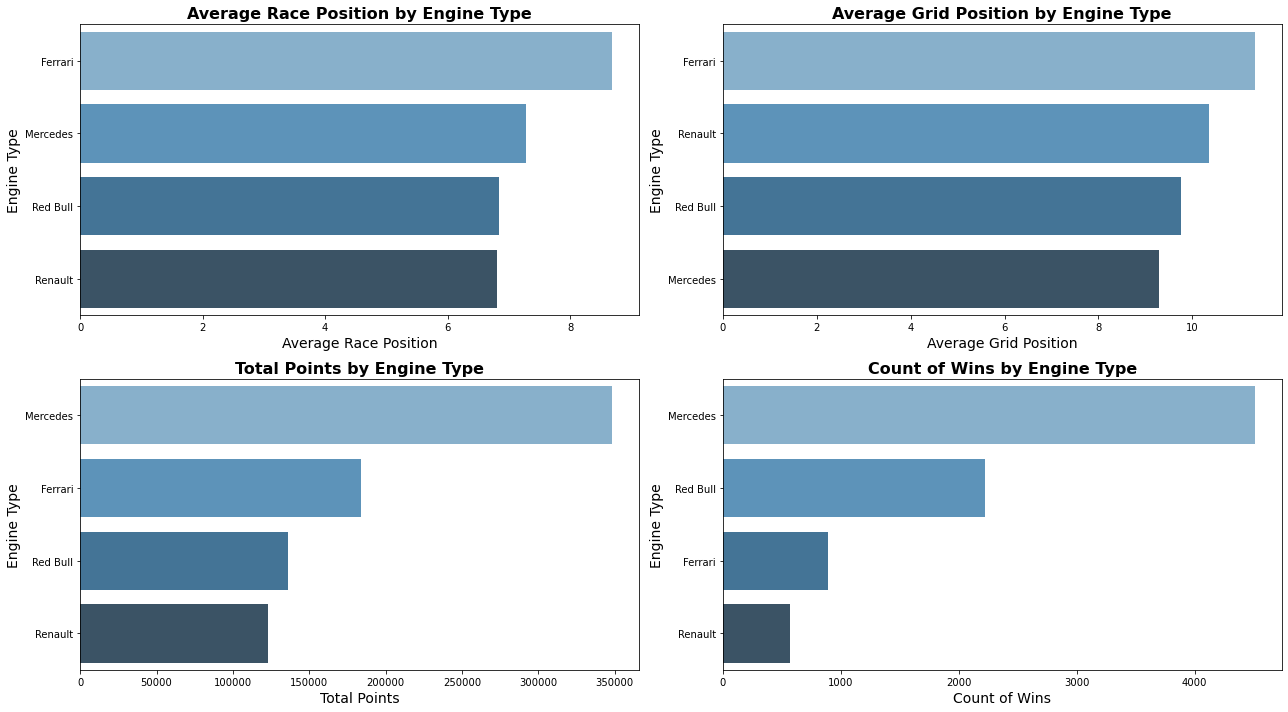

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = {
    'RACE': ('Average Race Position by Engine Type', 'Average Race Position'),
    'GRID POS': ('Average Grid Position by Engine Type', 'Average Grid Position'),
    'PTS': ('Total Points by Engine Type', 'Total Points'),
    'W': ('Count of Wins by Engine Type', 'Count of Wins')
}


fig, axs = plt.subplots(2, 2, figsize=(18, 10))  # 2 rows, 2 columns for subplots
axs = axs.flatten()  # Flatten to 1D array for iteration

# Loop through the metrics to create each subplot
for i, (metric, (title, xlabel)) in enumerate(metrics.items()):
    # Order the data
    order = grouped_by_engine.sort_values(metric, ascending=False).index
    
    # Create the barplot on the appropriate subplot
    sns.barplot(y=grouped_by_engine.index, x=grouped_by_engine[metric], 
                palette="Blues_d", order=order, ax=axs[i])
    
    axs[i].set_title(title, fontsize=16, fontweight='bold')
    axs[i].set_ylabel('Engine Type', fontsize=14)
    axs[i].set_xlabel(xlabel, fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Correlation between Grid Position and Final Race Position

We will now explore the potential correlation between grid position (the starting position in a race) and the final race position. This analysis will involve calculating the correlation coefficient between these two variables, along with the R² value, to assess the strength of their relationship. Additionally, we will create a scatter plot to visually examine and present the results of this analysis

In [57]:
correlation_gp_rc = merged_data["GRID POS"].corr(merged_data["RACE"])
correlation_gp_rc

0.5109804708915647

In [66]:
import statsmodels.api as sm

X = sm.add_constant(merged_data['GRID POS'])  # adding a constant
Y = merged_data['RACE']

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

print(model.rsquared)

0.26110104163256587


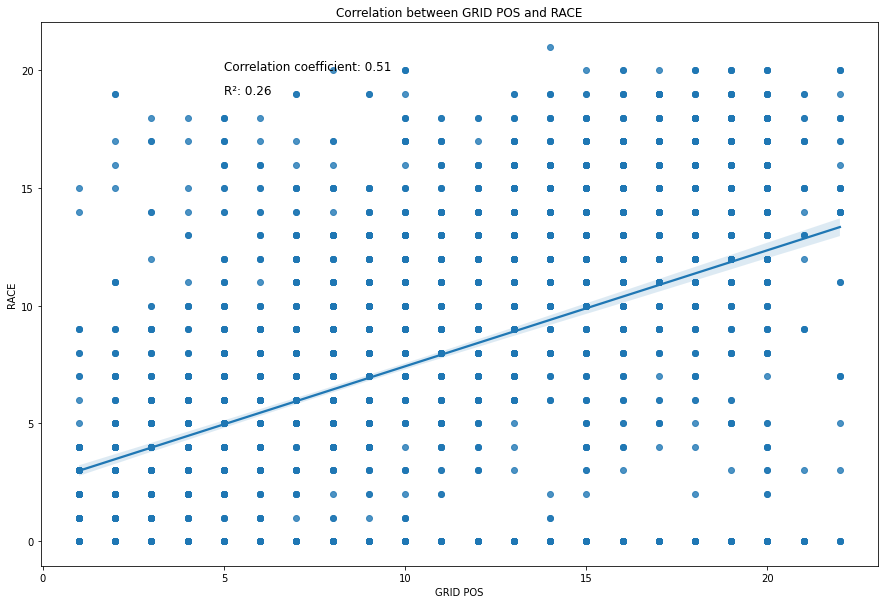

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.regplot(x='GRID POS', y='RACE', data=merged_data, ci=95)
plt.text(5, 20, f'Correlation coefficient: {correlation_gp_rc:.2f}', fontsize=12)
plt.text(5, 19, f'R²: {round(model.rsquared,2)}', fontsize=12)
plt.title('Correlation between GRID POS and RACE')
plt.xlabel('GRID POS')
plt.ylabel('RACE')
plt.show()

While the scatter plot suggests a linear trend between grid position and final race position, the correlation coefficient and R² value are not sufficiently strong to confirm a definitive correlation. This indicates that starting from a higher grid position does not necessarily guarantee a higher finish in the race. The relationship between these two variables appears to be more complex than a direct correlation

#### ANOVA Test for Statistical Significance

We will employ the ANOVA Test to determine if the type of engine significantly influences race performance. This test will help us understand whether the observed variations in performance are attributable to the engine type or are merely the result of random variation.

In [111]:
from scipy.stats import f_oneway

anova_results = f_oneway(*[group['RACE'] for name, group in merged_data.groupby('ENGINES')])
print(f"ANOVA Test Results: F-Statistic = {anova_results.statistic}, p-value = {anova_results.pvalue}")

# Interpret the results
if anova_results.pvalue < 0.05:
    print("There is a statistically significant difference in race performance across different engine types.")
else:
    print("There is no statistically significant difference in race performance across different engine types.")

ANOVA Test Results: F-Statistic = 21.614264774916343, p-value = 7.302979594969803e-14
There is a statistically significant difference in race performance across different engine types.


### POST HOC ANALYSIS

Following the results of the ANOVA test, which indicated significant differences but did not specify where these differences lie among groups, we have chosen to conduct a post hoc test. Specifically, we will utilize Tukey's HSD (Honestly Significant Difference) test. This test will enable us to pinpoint which specific engine types exhibit significant performance differences when compared with each other.

In [137]:
merged_data.to_csv("/Users/patricioulloa/UNI/UBC/Economic~DS/project/merged_data.csv")

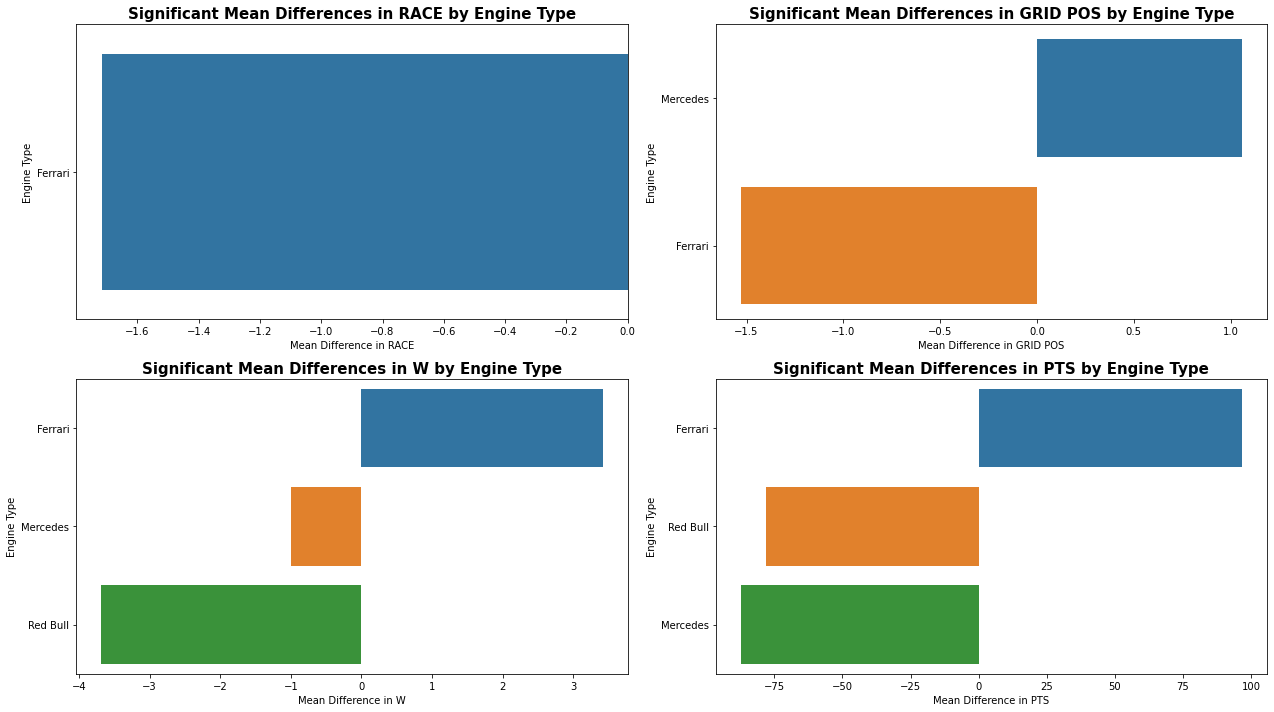

In [130]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

analysis_columns = ['RACE', 'GRID POS', 'W', 'PTS']

fig, axs = plt.subplots(2, 2, figsize=(18, 10)) # 2 rows, 2 columns for subplots
axs = axs.flatten() # Flatten the 2x2 array to 1D for easy iteration

for index, column in enumerate(analysis_columns):
    # Perform the Tukey HSD test for each column
    tukey_results = pairwise_tukeyhsd(endog=merged_data[column],
                                      groups=merged_data['ENGINES'].astype(str),
                                      alpha=0.05)
    tukey_results_df = pd.DataFrame(data=tukey_results._results_table.data[1:],
                                    columns=tukey_results._results_table.data[0])
    
    # Filter out the non-significant rows
    significant_results_df = tukey_results_df[tukey_results_df['reject'] == True]
    
    # Sort the significant results
    significant_results_df = significant_results_df.sort_values('meandiff', ascending=False)
    
    # Plot the significant results in the respective subplot
    sns.barplot(x='meandiff', y='group1', data=significant_results_df, errorbar=None, ax=axs[index])
    axs[index].set_xlabel('Mean Difference in ' + column, fontsize = 10)
    axs[index].set_ylabel('Engine Type', fontsize = 10)
    axs[index].set_title('Significant Mean Differences in ' + column + ' by Engine Type', fontsize = 15, fontweight="bold")

# Adjust the layout so the graphs are not overlapping
plt.tight_layout()
plt.show()

**From this graph, we can interpret the comparative performance of different engines. Bars extending to the right of the zero line on the y-axis indicate that the engine type has a higher average race position compared to the reference engine. Conversely, bars extending to the left suggest a better performance. The length of each bar represents the magnitude of the mean difference; longer bars signify a more significant difference in average race positions between the compared engine types** 

- It's important to note that in Formula 1, a higher average race position is not desirable since the winner is the one who finishes first. Hence, bars extending to the right indicate poorer performance, while those to the left indicate better performance.

#### Significance Mean Differences in RACE
In our analysis, which focuses only on significant results, the graph predominantly features engines made by Ferrari. The bars extending to the left signify that Ferrari engines tend to have a lower (and therefore better) average race position.

#### Significance Mean Differences in Grid Position
Regarding grid position, Ferrari engines show a trend of better performance. In contrast, Mercedes engines display a higher average grid position, which may be influenced by factors other than engine performance alone.

#### Significance Mean Differences in number of Wins
The data indicates that Red Bull engines lead in terms of the number of wins, followed by Mercedes and Ferrari. In this metric, Ferrari shows the least favorable performance, as indicated by its position far to the left.

#### Significance Mean Differences in number of Points
When it comes to accumulating points, Mercedes engines perform the best, followed by Red Bull and Ferrari. This suggests that Mercedes engines are more effective in securing the highest number of points.